In [1]:
from datetime import datetime, date, timedelta
import errno
import os
from os import walk
from os.path import join
from pathlib import Path
import re

from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import plotly.graph_objects as go

## Вспомогательные функции и константы с параметрами и заголовками

In [2]:
# Нужные параметры из файлов с данными
NEEDED_PARAMETERS = (
    "hmax",
    "FiltWindow",
    "Time Range",
    "Minimum duration of series",
    "time step"
)

# Заголовки колонок данных в текстовом файле
DATA_HEADERS = (
    "tsn", "time", "el", "az",
    "latp", "lonp", "tec",
    "tec_filtered", "validity"
)

DATASETS_DIR = "datasets"
IMAGES_DIR = "images"

In [3]:
if not os.path.exists(DATASETS_DIR):
    os.mkdir(DATASETS_DIR)

if not os.path.exists(IMAGES_DIR):
    os.mkdir(IMAGES_DIR)

In [4]:
def get_date_by_number(year=None, day_number=1):
    """Вычисление даты в заданном году по номеру дня.
    Возвращает значение в формате datetime с 0ч 0мин 0сек."""
    if year is None or year < 1970 or day_number <= 0:
        raise ValueError("Enter correct year/day number.")

    return datetime.combine(
        date(year, 1, 1) + timedelta(days=day_number-1),
        datetime.min.time()
    )

In [5]:
def get_day_number(year=1970, month=1, day=1, dt_format=None):
    """Вычисление номера дня в году по дате."""
    if dt_format:
        return dt_format.timetuple().tm_yday
    return date(year, month, day).timetuple().tm_yday

In [6]:
def parse_filename(filename=""):
    """Парсинг имени файла на: stk2G20_165.dat
       stk2 - имя пункта гнсс (4 символа),
       G20 - тип и номер спутника (3 символа),
       165 - номер дня в году"""
    # TODO: добавить обработку ошибок
    name, _ = os.path.basename(filename).split(".")
    name_part, day_number = name.split("_")
    return {
        "day_number": int(day_number),
        "receiver_name": name_part[:4],  # TODO: уточнить англ. термин
        "sat_name": name_part[4:7],
    }

In [7]:
def get_params_datafile(filename=""):
    """Функция для сбора параметров из файла .dat
    из строк в начале файла начинающихся с символа #.
    Возвращает словарь.
    """
    if not filename:
        raise ValueError("Filename is needed.")

    if not os.path.isfile(filename):
        raise FileNotFoundError(
            errno.ENOENT,
            os.strerror(errno.ENOENT),
            filename
        )

    params = []

    with open(filename, 'r') as tec_file:
        for line in tec_file.readlines():
            if line.strip().startswith("#"):  # это параметр
                param = line.strip()[1:]
                param = param.split("=")
                if len(param) != 2:  # заголовки пропускаем
                    continue
                param = tuple(el.strip() for el in param)
                params.append(param)
    
    params = dict(params)

    # оставляем только нужные параметры
    return {
        key: params[key]
        for key
        in NEEDED_PARAMETERS
    }

In [8]:
def get_dataframe_datafile(filename=""):
    """Возвращает датафрейм с данными из текстового файла TEC.
    Заголовки задаются в константе."""
    return pd.read_csv(
        filepath_or_buffer=filename,
        delim_whitespace=True,  # разделитель - пробел(ы)
        comment="#",  # пропускаем комменты
        names=DATA_HEADERS, # задание заголовков из списка
    )

In [9]:
def plot_save_waveform(df=None, plot_label='', plot_filename='',
                  time_start=None, time_end=None,
                  xname="", yname=""):
    """Создание графика по данным датафрейма и сохранение в файл."""
    # отбор интервала времени
    # TODO: вынести/убрать
    if time_start and time_end:
        df = df[
            (df["timestamp"] >= time_start) & (df["timestamp"] <= time_end)
        ]

    fig = plt.figure(figsize=(8, 2.8), dpi=300)
    axs = fig.add_axes([0.1, 0.3, 0.85, 0.65])  #  left, bottom, width, height

    if time_start and time_end:
        axs.set_xlim(time_start, time_end)
    axs.set_ylim(-0.1, 0.1)

    df.plot(
        x=xname, y=yname,
        legend=False, ax=axs,
        color='r', linewidth=2
    )

    at = AnchoredText(
        anchored_text_label,
        loc='upper right',
        prop=dict(size=12),
        frameon=False,
    )
    axs.add_artist(at)
    #  Устанавливаем интервал основных и вспомогательных делений
    axs.xaxis.set_major_locator(md.MinuteLocator(byminute=[0,30,60], interval=1))
    axs.xaxis.set_minor_locator(md.MinuteLocator(byminute=[0,3,6,7,10], interval=1))
    axs.yaxis.set_major_locator(ticker.MultipleLocator(.05))
    axs.yaxis.set_minor_locator(ticker.IndexLocator(base=0.5, offset=0.25))
    axs.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    #  Добавляем линии основной сетки:
    axs.grid(which='major', color='k', linestyle='-', linewidth=0.5)
    #  Включаем видимость вспомогательных делений:
    axs.minorticks_on()
    #  plt.tight_layout()
    fig.autofmt_xdate()
    fig.savefig(plot_filename)

    return plot_filename

In [10]:
def dat_to_df(filename='', year=1970):
    """Открывает файл .dat, отбирает столбцы времени и значение TEC,
    преобразовывет форматы. Возвращает датафрейм."""
    name, _ = os.path.basename(filename).split(".")
    file_name_parts = parse_filename(filename)
    # для проверки формата имени файла - что это файл с данными
    # TODO: вынести?
    file_name_template = '^\w{4,4}[G,R]\d\d_\d\d\d$'
    if re.match(file_name_template, name) is None:
        raise TypeError
    
    dataframe = pd.read_csv(
        filepath_or_buffer=filename,
        delim_whitespace=True,  # разделитель - пробел(ы)
        comment="#",  # пропускаем комменты
        names=DATA_HEADERS, # задание заголовков из списка
    )

    # добавление даты, для дальнейшего удобства
    # TODO: вынести?
    dt = get_date_by_number(
        year=year,
        day_number=file_name_parts['day_number']
    )
    dataframe["time"] = pd.to_timedelta(
        dataframe["time"], unit='h'
    ).add(dt).astype('datetime64[s]')

#     if time_start and time_end:
#         dataframe = dataframe[
#             (dataframe["time"] >= time_start) & (dataframe["time"] <= time_end)
#         ]  # отбор интервала времени

    return dataframe[["time", "tec_filtered"]].rename(
        columns={"time": "timestamp", "tec_filtered": "value"}
    )

In [11]:
def get_file_list(path="", template=".*"):
    """Сбор всех файлов из указанной директории с именами подходящих по шаблону."""
    file_list = []

    for (dirpath, dirnames, filenames) in walk(path):
        for filename in filenames:
            if re.match(template, filename) is not None:
                file_list.append(
                    join(dirpath, filename)
                )

    return file_list

In [12]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
    print(b.files) # Print the list of files selected.

fileselect = Button(description="File select")
fileselect.on_click(select_files)

display(fileselect)

Button(description='File select', style=ButtonStyle())

## Работа с данными

### 1. Выбор файла dat

In [13]:
fc = FileChooser('.')
display(fc)

fc.default_path = '.'
fc.reset()
fc.show_hidden = False
fc.use_dir_icons = True

fc.filter_pattern = ['*.dat',]
fc.title = '<b>Выберите файл с данными</b>'

# Sample callback function
# def change_title(chooser):
#     chooser.title = '<b>Callback function executed</b>'

# Register callback function
# fc.register_callback(change_title)

FileChooser(path='.', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden='False',…

### 2. Преобразование данных из файла dat в датафрейм

In [16]:
df = dat_to_df(filename=fc.selected, year=2009)
df.head()

,timestamp,value
0,2009-06-14 06:15:29,0.00000
1,2009-06-14 06:16:00,-0.00345
2,2009-06-14 06:16:30,0.00525
3,2009-06-14 06:16:59,0.00624
4,2009-06-14 06:17:30,0.00138


### 3. Построение графика (Matplotlib)

'images\\0010G20_165'

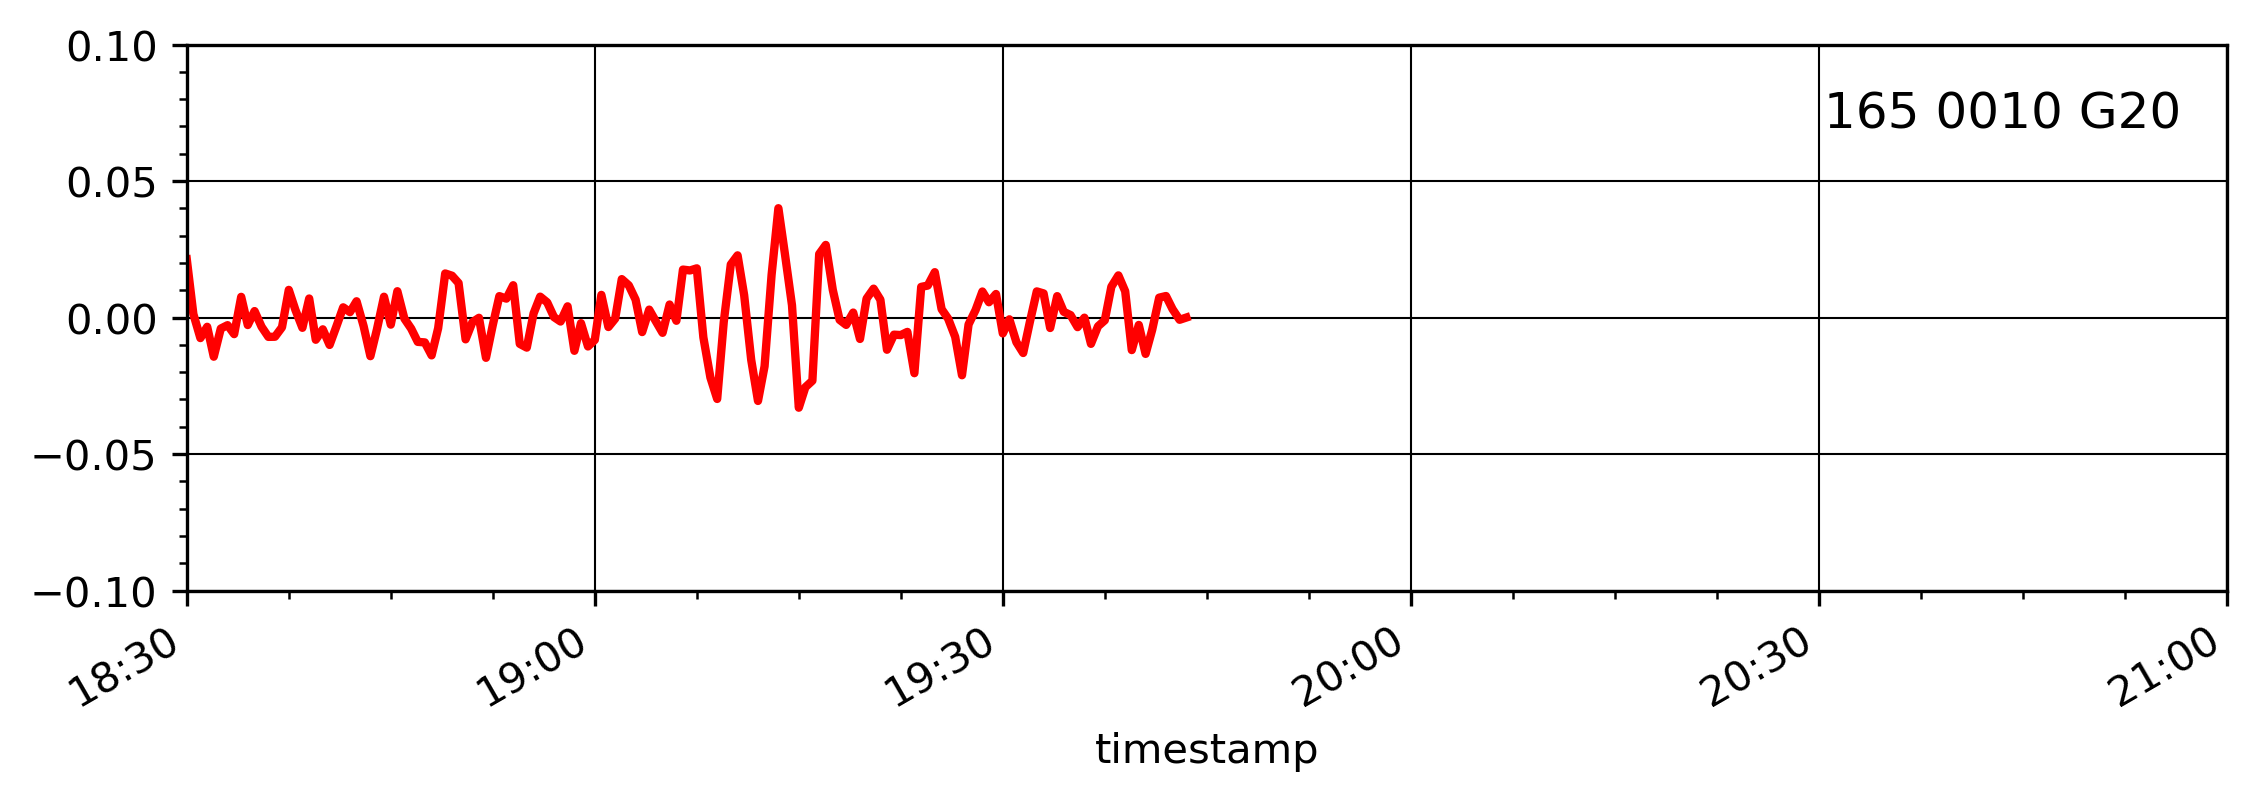

In [17]:
# ts = pd.to_datetime(18.50, unit='h')
# te = pd.to_datetime(21.00, unit='h')

ts = pd.to_datetime('2009-06-14 18:30:00')
te = pd.to_datetime('2009-06-14 21:00:00')

name, _ = os.path.basename(fc.selected).split(".")
plot_filename = join(IMAGES_DIR, name)

file_name_parts = parse_filename(fc.selected)

anchored_text_label = (
    f"{file_name_parts['day_number']}"
    f" {file_name_parts['receiver_name']}"
    f" {file_name_parts['sat_name']}"
)

plot_save_waveform(
    df=df,
    plot_label=anchored_text_label,
    plot_filename=plot_filename,
    time_start=ts, time_end=te,
    xname='timestamp', yname='value'
)

### 4. Построение графика (Plotly)

In [19]:
# отбор интервала времени
df = df[
    (df["timestamp"] >= ts) & (df["timestamp"] <= te)
]

layout = dict(xaxis=dict(title='Time, hours (UT)'),
              yaxis=dict(title='Filtered TEC, TECU'))

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value'], 
                         mode='markers', name='data markers',
                         marker=dict(color='blue')))

fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value'], 
                         mode='lines', name='data lines',
                         marker=dict(color='red')))

fig.update_layout(autosize=False,
                  width = 950,
                  height = 350,
                  title={'text': anchored_text_label})

fig.update_layout(yaxis_range=[-0.1,0.1],
                  xaxis_range=[ts, te])

fig.update_yaxes(scaleanchor = "x",
                 scaleratio = 2)

fig.show()

### 5. Сохранение датафрейма в файл csv

In [20]:
filename, _ = os.path.basename(fc.selected).split(".")
df.to_csv(
    join(DATASETS_DIR, filename+'.csv'),
    index=False
)

In [21]:
get_date_by_number(year=2009, day_number=165)

datetime.datetime(2009, 6, 14, 0, 0)

## Создание датасетов

In [37]:
# некоторые параметры
dataset_name = "test"
dataset_day = "165"
year = 2009 # подразумевается что все данные одного года

train_tec_data_path = 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165'

### 1. Сбор файлов dat с данными

In [38]:
file_list = get_file_list(path=train_tec_data_path,
                          template='^\w{4,4}[G,R]\d\d_\d\d\d\.dat$')
file_list

['C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G20\\0010G20_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G20\\0118G20_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G20\\0505G20_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G20\\0784G20_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G20\\stk2G20_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G23\\0108G23_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G23\\0519G23_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G23\\0784G23_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G23\\0869G23_165.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\165\\G23\\SHIKG23_165.dat']

### 2. Конвертация данных в датафреймы и объединение в один

In [39]:
dataframes = []

for file_name in file_list:
    dataframes.append(
       dat_to_df(filename=file_name, year=year)
    )

df = pd.concat(dataframes, ignore_index=True)

df

,timestamp,value
0,2009-06-14 06:15:29,0.00000
1,2009-06-14 06:16:00,-0.00345
2,2009-06-14 06:16:30,0.00525
3,2009-06-14 06:16:59,0.00624
4,2009-06-14 06:17:30,0.00138
...,...,...
9313,2009-06-14 20:58:59,-0.00161
9314,2009-06-14 20:59:30,0.00250
9315,2009-06-14 21:00:00,-0.00105
9316,2009-06-14 21:00:29,-0.00013


### 3. Сохранение датафрейма в файл csv

In [40]:
csv_file = dataset_name + '.csv'
df.to_csv(
    join(DATASETS_DIR, csv_file),
    index=False
)

## Построение графика для каждого файла .dat  в папке

In [27]:
# тип сохраняемого файла определяется по расширению
plots_filename = "all_166.pdf"

### 1. Сбор файлов

In [32]:
data_path = "C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\"

file_list = get_file_list(path=data_path,
                          template='^\w{4,4}[G,R]\d\d_\d\d\d\.dat$')

file_list

['C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G21\\0004G21_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G21\\0507G21_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G21\\0519G21_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G21\\0859G21_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G21\\KUNAG21_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G21\\SHIKG21_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G24\\0009G24_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G24\\0115G24_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G24\\0119G24_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G24\\0519G24_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G24\\0784G24_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G24\\SHIKG24_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G28\\0108G28_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC_DATA\\166\\G28\\0864G28_166.dat',
 'C:\\Users\\Alex\\Devel\\TEST_TEC

### 2. Сбор данных из файлов dat в датафреймы

In [33]:
dataframes = []

for file_name in file_list:
    name, _ = os.path.basename(file_name).split(".")
    dataframes.append(
       {
           "data": dat_to_df(filename=file_name, year=2009),
           "name": name,
       }
    )

dataframes

[{'data':                timestamp    value
  0    2009-06-15 00:00:00  0.00000
  1    2009-06-15 00:00:29  0.00074
  2    2009-06-15 00:01:00 -0.00044
  3    2009-06-15 00:01:30 -0.00285
  4    2009-06-15 00:01:59 -0.00647
  ...                  ...      ...
  1035 2009-06-15 23:57:29  0.00164
  1036 2009-06-15 23:58:00  0.00885
  1037 2009-06-15 23:58:30 -0.00405
  1038 2009-06-15 23:58:59 -0.00236
  1039 2009-06-15 23:59:30  0.00000
  
  [1040 rows x 2 columns],
  'name': '0004G21_166'},
 {'data':                timestamp    value
  0    2009-06-15 00:00:00  0.00000
  1    2009-06-15 00:00:29 -0.00218
  2    2009-06-15 00:01:00  0.00332
  3    2009-06-15 00:01:30 -0.00301
  4    2009-06-15 00:01:59 -0.00738
  ...                  ...      ...
  1056 2009-06-15 23:57:29  0.01481
  1057 2009-06-15 23:58:00 -0.00781
  1058 2009-06-15 23:58:30 -0.00640
  1059 2009-06-15 23:58:59 -0.00059
  1060 2009-06-15 23:59:30  0.00000
  
  [1061 rows x 2 columns],
  'name': '0507G21_166'},
 {'data'

### 3. Отрисовка графиков для каждого датафрейма

In [35]:
from plotly.subplots import make_subplots

width = 1000
height = 350

titles = (
    df['name'] for df in dataframes
)

fig = make_subplots(
    rows=len(dataframes), cols=1,
    subplot_titles=tuple(titles)
)

for i, df in enumerate(dataframes, 1):
    df = df['data']
    
#     df = df[
#         (df["timestamp"] >= ts) & (df["timestamp"] <= te)
#     ]

    fig.append_trace(go.Scatter(
        x=df['timestamp'],
        y=df['value'],
        marker=dict(color='red')
    ), row=i, col=1)
     
#     fig.append_trace(go.Scatter(
#         x=df['data']['timestamp'],
#         y=df['data']['value'],
#         mode='markers',
#         marker=dict(color='blue'),
#     ), row=i, col=1)
    
    fig.update_xaxes(
        title_text="Time, hours (UT)",
        row=i, col=1
    )
    fig.update_yaxes(
        title_text="Filtered TEC, TECU",
        row=i, col=1
    )

fig.update_layout(yaxis_range=[-0.1, 0.1])

fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 2
  )

fig.update_layout(height=height*len(dataframes),
                  width=width)

fig.update_layout(showlegend=False)
fig.show()

### 4. Сохранение графиков в файл

In [36]:
fig.write_image(
    join(IMAGES_DIR, plots_filename)
)